# Exercise (3)

Goal of this exercise is to implement the **Bisection** Method for symmetrical matrizes to find the eigenvalues. For this we want to calculate the eigenvalues of the following matrix

\begin{equation}
A = \begin{pmatrix}
-2 & 1 & 0 & ...& 0 \\
1 & ...& ...& ...& 0 \\
0 & ...& ...& ...& 0 \\
... & ... & ... & ... & 0 \\
0 & 0 & 0 & 1 & -2 
\end{pmatrix} \in \mathbb{R}^{10 \times 10}
\end{equation}

At first we bring the matrix to the Hessenberg form. We are allowed to use **scipy.linalg.hessenberg** for this.






### Definition Hessenberg-Form

A square matrix with $h_{ij} = 0$ for $i\geq j+2$ is called Hessenberg-Matrix

Transformation with Householder-Reflections.

Remember that the Householder-Reflection is defined as

\begin{equation}
H = I - 2 u u^T
\end{equation}


**Transformation to Hessenberg-Form**

1. For each column $k$ from $0,n-2$ we identify the vector below the diagonal to zero out
2. Then create a Householder-Reflection for this Vector
3. Apply this Reflector to A from both sides

In [128]:
import numpy as np
from scipy.linalg import hessenberg

def householder_reflection(v):
    """ 
    Creates a householder reflection for the vector v
    """
    u = v.copy()
    # Choose a sign to avoid numerical issues
    u[0] += np.sign(v[0]) * np.linalg.norm(v)
    u /= np.linalg.norm(u) # Normalize u
    return np.eye(len(v)) - 2 * np.outer(u, u) # Householder matrix

def hessenberg_reduction(A):
    """
    Transforms a symmetric matrix A to tridiagonal Hessenberg form
    """
    A = A.copy().astype(float) 
    n = A.shape[0]

    for k in range(n-2):
        # Vector to zero out below the k-th subdiagonal
        x = A[k+1:, k]

        # Skip if already zero
        if np.allclose(x[1:] , 0):
            continue

        # Create householder reflection
        H_k = householder_reflection(x)

        # Embed in full size matrix
        H_full = np.eye(n)
        H_full[k+1:, k+1:] = H_k

        # Apply the transformation
        A = H_full @ A @ H_full.T
    
    return A

In [129]:
# Test matrix

A = np.array([[4, 1, 2, 3],
              [1, 5, 6, 7],
              [2, 6, 8, 9],
              [3, 7, 9, 10]])

# Hessenberg with scipy
A_scipy = hessenberg(A)
# Custom Hessenberg reduction
A_custom = hessenberg_reduction(A)
# Print results
print("---------Hessenberg form using custom function:-------------\n", A_custom)
print("")
print("---------Hessenberg form using scipy:---------------------\n", A_scipy)

# Check if the results are close
print("Are the results close?", np.allclose(A_custom, A_scipy))

---------Hessenberg form using custom function:-------------
 [[ 4.00000000e+00 -3.74165739e+00  2.43135199e-16  4.32902192e-16]
 [-3.74165739e+00  2.15000000e+01 -5.33519313e+00  7.77156117e-16]
 [ 2.43135199e-16 -5.33519313e+00  1.30301129e+00  2.05895110e-01]
 [ 4.32902192e-16  2.22044605e-16  2.05895110e-01  1.96988708e-01]]

---------Hessenberg form using scipy:---------------------
 [[ 4.00000000e+00 -3.74165739e+00  4.64923116e-16  4.22228551e-16]
 [-3.74165739e+00  2.15000000e+01 -5.33519313e+00  8.88178420e-16]
 [ 0.00000000e+00 -5.33519313e+00  1.30301129e+00  2.05895110e-01]
 [ 0.00000000e+00  0.00000000e+00  2.05895110e-01  1.96988708e-01]]
Are the results close? True


**Bisection for Symmetrical Matrices**

We set $A_1 = [d_1], A_2 = \begin{pmatrix} d_1 & e_2 \\ e_2 & d_2 \end{pmatrix}, A_3 = \begin{pmatrix} d_1 & e_2 & 0 \\ e_2 & d_2 & e_3 \\ 0 & e_3 & d_3 \end{pmatrix}, ...$ and so on.

And defines the polynomials $p_i(\lambda) = \det(A_i - \lambda I)$.

Now the Matrix $A$ defines a Sturm-Chain and $W(b)- W(a)$ is the number of eigenvalues in the interval $[a,b)$ Here $W(\lambda)$ is the number of sign changes in $[p_0(\lambda), p_1(\lambda), ..., p_n(\lambda)]$.

1. We search for a interval [a,b)$ such that all eigenvalues of $A$ are contained in this interval (by using Gerschogin's theorem) then $W(a) = 0, W(b) = n$ 
2. Next we set $c = (a+b)/2$ and calculate $W(c)$ 
3. $W(c) - W(a)$ is the number of eigenvalues in the interval $[a,c)$
4. $W(b) - W(c)$ is the number of eigenvalues in the interval $[c,b)$
5. Each of this interval that contains at least on eigenvalue is split sucessively

For the calculation of $p_n(\lambda)$ often overflow errors occur if $n$ is big and $|\lambda|$ is big. For this we better use

$f_i (\lambda) = \frac{p_i(\lambda)}{p_{i-1}(\lambda)}, i = 1, ..., n$

Now notice that

+ $W(\lambda)$ = Number of sign changes in [$p_0(\lambda), p_1(\lambda), ..., p_n(\lambda)$] is the same as number of negative elements in [$f_1(\lambda), f_2(\lambda), ..., f_n(\lambda)$]

#### Final remark on $f_i(\lambda)$

The sequence of $f_i(\lambda)$ fulfilles the recursion $f_1(\lambda) = d_1 - \lambda$ and 

\begin{equation}
f_i(\lambda) = \begin{cases} d_i - \lambda - \frac{e_i^2}{f_{i-1}(\lambda)}, f_{i-1}(\lambda) \neq 0 \\ -\infty , f_{i-1}(\lambda) = 0 \end{cases}
\end{equation}


Alternatively we modify the recursion to $\tilde{f}_1(\lambda = d_1 - \lambda$ and

\begin{equation}
\tilde{f}_i(\lambda) = d_1 - \lambda - \begin{cases} \frac{e_i^2}{\tilde{f}_{i-1}(\lambda)}, if |\tilde{f}_{i-1}(\lambda)| \geq |e_i|*eps \\
\frac{|e_i|}{eps} ~ if |\tilde{f}_{i-1}(\lambda)| < |e_i|*eps \\ 
\end{cases}
\end{equation}

In [130]:
def sturm_sequence_recursion(A, lam):
    """
    Compute W(\lambda) using the ratio approach f_i = p_i / p_{i-1}
    
    Uses the recurison formula given in the script
    """
    n = A.shape[0]
    d = np.diag(A) - lam # Diagonal elements minus lambda
    e = np.diag(A, k=-1) # subdiagonal elements

    # Initialize p_0(lamda) = 1
    if n == 0:
        return 0, np.array([])

    f_values = np.zeros(n)
    f_values[0] = d[0] #f_1 = d_1 - \lambda

    

    count = 1 if f_values[0] < 0 else 0 # Initialize the count

    for i in range(1,n):
        if np.isclose(f_values[i-1], 0, atol=1e-12):
            # Special case when f_{i-1} is zero --> treated as infinity we will see if this causes problems
            f_values[i] = -np.inf
        else:
            # Apply recursion f_i = d_i - lambda - e_i^2 / f_{i-1}
            f_values[i] = d[i] - lam - (e[i-1]**2 / f_values[i-1])

        # now count negative values also - \infty is count as negative
        if f_values[i] < 0:
            count += 1
    #print("f_values:", f_values)
    return count, f_values



Alternative implementation given below **Lemma 5.21**

In [131]:

def modified_sturm_count(A, λ, eps=None):
    """
    Compute W(λ) using the modified recursion for f_i with numerical stability safeguards
    
    Args:
        A: Symmetric tridiagonal matrix
        λ: Current shift value
        eps: Optional machine epsilon override (default uses numpy's eps for float64)
    
    Returns:
        count: Number of eigenvalues < λ
        f_values: The sequence of f_i values (for debugging)
    """
    n = A.shape[0]
    if eps is None:
        eps = np.finfo(float).eps
    
    d = np.diag(A) - λ
    e = np.diag(A, k=-1)
    
    f_values = np.zeros(n)
    f_values[0] = d[0]  # f_1_tilde = d[0] - λ
    count = 1 if f_values[0] < 0 else 0
    
    for i in range(1, n):
        if np.abs(f_values[i-1]) >= np.abs(e[i-1]) * eps:
            # Standard case
            f_values[i] = d[i] - (e[i-1]**2) / f_values[i-1]
        else:
            # Safeguard case
            f_values[i] = d[i] - np.abs(e[i-1]) / eps
        
        # Count sign changes (negative values)
        if f_values[i] < 0:
            count += 1
    
    return count, f_values

Now with this taken care of we can implement the Bisection Method for Symmetrical Matrices.

In [132]:
def gershgorin_bounds(A):
    """
    Compuntes the initial interval [a,b] containing all eigenvalues of A
    """ 
    n = A.shape[0]
    d = np.diag(A)
    e = np.diag(A, k=-1)  # subdiagonal elements

    if n == 1:
        return [d[0], d[0]]  # Single element case
    
    radii = np.zeros(n)
    radii[0] = np.abs(e[0])  # First row radius
    radii[-1] = np.abs(e[-1])  # Last row radius

    for i in range(1, n-1):
        radii[i] = np.abs(e[i-1]) + np.abs(e[i]) # Middle row
    
    # Find the bounds
    lower = np.min(d - radii)
    upper = np.max(d + radii)

    # SLigth padding for numerical stability
    padding = 0.001 * (upper - lower)
    return lower - padding, upper + padding

In [133]:
def symmetric_bisection(A,tol=1e-10,max_iter=10, method="sturm_v1"):
    """
    Compute all the eigenvalues of a symmetric tridiagonal matrix A using the bisection method
    awith the Sturm sequence recursion approach.

    Args:
        A (np.ndarray): Symmetric tridiagonal matrix.
        tol (float): Tolerance for convergence.
        max_iter (int): Maximum number of iterations.
        method (str): Method to use for Sturm sequence recursion. 
            Options are "sturm_v1" for the original version and "sturm_v2" for the modified version.
    """
    n = A.shape[0]
    a,b = gershgorin_bounds(A)  # Get the initial bounds using Gershgorin circles
    
    #print(f"Initial bounds: [{a}, {b}]")

    eigenvalues = []
    def bisect(lower,upper,count_lower,count_upper):
        """  
        Performs the recurisive bisection to find the eigenvalues
        """
        if count_upper - count_lower == 0:
            # No eigenvalues in this interval
            return 
        if count_upper - count_lower == 1:
            # Isolate the single eigenvalue with a binary search
            left,right = lower, upper
            for _ in range(max_iter):
                mid = (left + right)/ 2
                if method == "sturm_v1":
                    W_mid, _ = sturm_sequence_recursion(A, mid)
                elif method == "sturm_v2":
                    W_mid, _ = modified_sturm_count(A, mid)
                if W_mid > count_lower:
                    # Update the lower bound
                    right = mid  
                else:
                    # Update the upper bound
                    left = mid
                
                if right - left < tol:
                    eigenvalues.append((left + right) / 2)
                    return 
        # Case that there are multiple eigenvalues in the interval
        # --> Bisect even further
        mid = (lower + upper) / 2
        if method == "sturm_v1":
            W_mid, _ = sturm_sequence_recursion(A, mid)
        elif method == "sturm_v2":
            W_mid, _ = modified_sturm_count(A, mid)
        bisect(lower, mid, count_lower, W_mid)
        bisect(mid, upper, W_mid, count_upper)

    # Initial count of eigenvalues in the interval
    if method == "sturm_v1":
        W_a, _ = sturm_sequence_recursion(A, a)  # Should be 0
    elif method == "sturm_v2":
        W_a, _ = modified_sturm_count(A, a)  # Should be 0
    else:
        raise ValueError("Invalid method specified. Use 'sturm_v1' or 'sturm_v2'.")
   
    if method == "sturm_v1":
        W_b, _ = sturm_sequence_recursion(A, b)
    elif method == "sturm_v2":
        W_b, _ = modified_sturm_count(A, b)
    else:
        raise ValueError("Invalid method specified. Use 'sturm_v1' or 'sturm_v2'.")

    # Start the bisection process
    bisect(a, b, W_a, W_b)
    return sorted(eigenvalues)
            

In [134]:
#Create a test matrix (10x10 tridiagonal)
def create_test_matrix(n, main_diag=-2, off_diag=1):
    A = np.zeros((n, n))
    np.fill_diagonal(A, main_diag)
    np.fill_diagonal(A[1:], off_diag)
    np.fill_diagonal(A[:, 1:], off_diag)
    return A

n = 10
A_test = create_test_matrix(n)
print("Test matrix:\n", A_test)

Test matrix:
 [[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


In [135]:
# Compute eigenvalues using symmetric bisection
eigenvalues = symmetric_bisection(A_test,method="sturm_v2")
print("Eigenvalues using symmetric bisection:", eigenvalues)

# Verify with numpy's eigenvalue computation
eigenvalues_np = np.linalg.eigvalsh(A_test)
print("Eigenvalues using numpy:", eigenvalues_np)

Eigenvalues using symmetric bisection: [-3.9189859472148236, -3.6825070656401224, -3.3097214678852462, -2.8308300259858945, -2.2846296765583682, -1.7153703234416318, -1.1691699740141046, -0.6902785321147529, -0.3174929343598778, -0.08101405278517629]
Eigenvalues using numpy: [-3.91898595 -3.68250707 -3.30972147 -2.83083003 -2.28462968 -1.71537032
 -1.16916997 -0.69027853 -0.31749293 -0.08101405]


In [138]:
def compute_eigenvalues(A):
    """
    Complete pipeline also with Hessenberg reduction
    """
    H = hessenberg_reduction(A)

    H = np.triu(H,-1) # Ensure it's upper Hessenberg

    return symmetric_bisection(H, method="sturm_v2")

# Test with random symmetric matrices
np.random.seed(42)
for n in [5, 10, 15]:  # Test different sizes
    print(f"\nRandom symmetric {n}x{n} matrix:")
    A_random = np.random.rand(n, n)
    A_random = (A_random + A_random.T)/2  # Make symmetric
    
    our_eigs = compute_eigenvalues(A_random)
    numpy_eigs = np.linalg.eigvalsh(A_random)
    
    print("Our method:", np.sort(our_eigs))
    print("NumPy:", np.sort(numpy_eigs))
    print("Max difference:", np.max(np.abs(np.sort(our_eigs) - np.sort(numpy_eigs))))


Random symmetric 5x5 matrix:
Our method: [-0.65704256 -0.01451249  0.09903903  0.46111753  2.26447987]
NumPy: [-0.65704256 -0.01451249  0.09903903  0.46111753  2.26447987]
Max difference: 2.6791457941044428e-11

Random symmetric 10x10 matrix:
Our method: [-0.88780177 -0.63965048 -0.48428241 -0.28372488  0.16862489  0.31659059
  0.61292503  0.79942478  1.03030888  4.93631708]
NumPy: [-0.88780177 -0.63965048 -0.48428241 -0.28372488  0.16862489  0.31659059
  0.61292503  0.79942478  1.03030888  4.93631708]
Max difference: 2.9039159965549288e-11

Random symmetric 15x15 matrix:
Our method: [-1.47918189 -1.28345229 -1.11526937 -0.88191487 -0.7367394  -0.6077377
 -0.36804747 -0.21875375  0.12493873  0.17263771  0.45721752  0.66217758
  1.18061044  1.2087114   7.48852038]
NumPy: [-1.47918189 -1.28345229 -1.11526937 -0.88191487 -0.7367394  -0.6077377
 -0.36804747 -0.21875375  0.12493873  0.17263771  0.45721752  0.66217758
  1.18061044  1.2087114   7.48852038]
Max difference: 4.710365431037644e-

This looks really good i would say, now finally we can make a plot that shows the errors when using the method for different matrix sizes

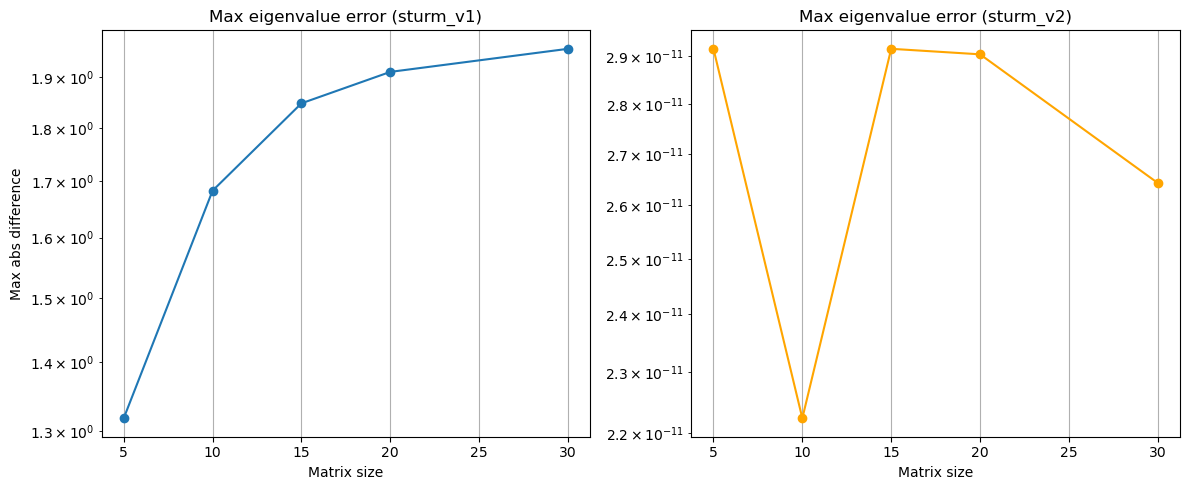

In [143]:
import matplotlib.pyplot as plt

matrix_sizes = [5, 10, 15, 20, 30]
max_diffs_v2 = []
max_diffs_v1 = []

for n in matrix_sizes:
    A = create_test_matrix(n)
    eigs_v1 = symmetric_bisection(A, method="sturm_v1")
    eigs_v2 = symmetric_bisection(A, method="sturm_v2")
    eigs_np = np.linalg.eigvalsh(A)
    max_diffs_v1.append(np.max(np.abs(np.sort(eigs_v1) - np.sort(eigs_np))))
    max_diffs_v2.append(np.max(np.abs(np.sort(eigs_v2) - np.sort(eigs_np))))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs[0].plot(matrix_sizes, max_diffs_v1, marker='o', label='sturm_v1')
axs[0].set_title('Max eigenvalue error (sturm_v1)')
axs[0].set_xlabel('Matrix size')
axs[0].set_ylabel('Max abs difference')
axs[0].set_yscale('log')
axs[0].grid(True)

axs[1].plot(matrix_sizes, max_diffs_v2, marker='o', color='orange', label='sturm_v2')
axs[1].set_title('Max eigenvalue error (sturm_v2)')
axs[1].set_xlabel('Matrix size')
axs[1].set_yscale('log')
axs[1].grid(True)

plt.tight_layout()
plt.show()

This shows us that really along all the different matrix sizes the sturm_v2 method given below lemma 5.21 performs good we should also maybe track the computational time for the different matrix sizes


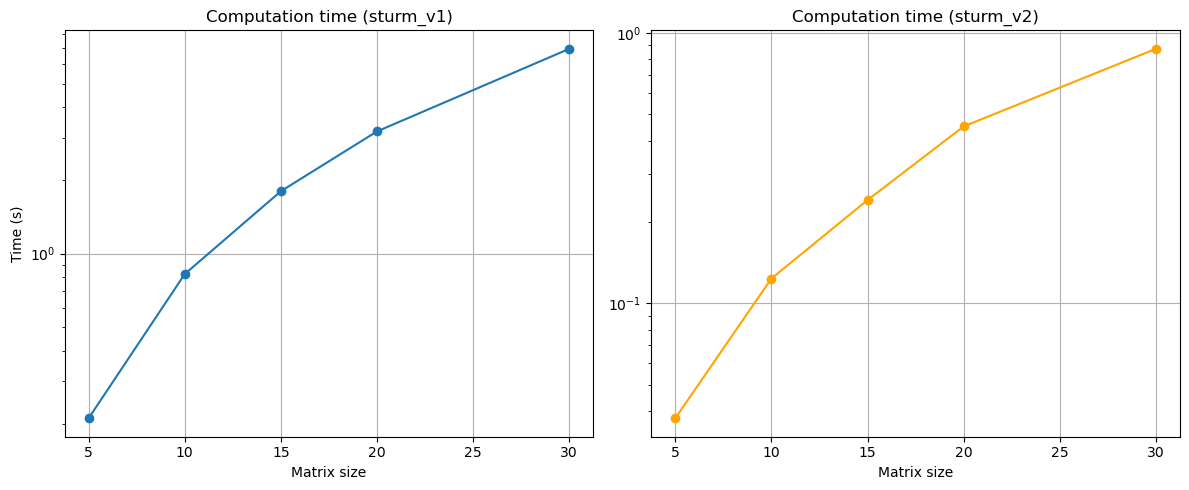

In [144]:
import time

times_v1 = []
times_v2 = []

for n in matrix_sizes:
    A = create_test_matrix(n)
    
    start = time.time()
    symmetric_bisection(A, method="sturm_v1")
    times_v1.append(time.time() - start)
    
    start = time.time()
    symmetric_bisection(A, method="sturm_v2")
    times_v2.append(time.time() - start)

fig_time, axs_time = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axs_time[0].plot(matrix_sizes, times_v1, marker='o', label='sturm_v1')
axs_time[0].set_title('Computation time (sturm_v1)')
axs_time[0].set_xlabel('Matrix size')
axs_time[0].set_ylabel('Time (s)')
axs_time[0].set_yscale('log')
axs_time[0].grid(True)

axs_time[1].plot(matrix_sizes, times_v2, marker='o', color='orange', label='sturm_v2')
axs_time[1].set_title('Computation time (sturm_v2)')
axs_time[1].set_xlabel('Matrix size')
axs_time[1].set_yscale('log')
axs_time[1].grid(True)

plt.tight_layout()
plt.show()

We can see here also how the computation time scales with the matrix size, but again the sturm_v2 method performs better than the other one